# CS 109A/Final Project: Data Processing and EDA  
  
Group 3: Ning Shen, Lars von Buchholtz

  
        
Alzheimer's disease (AD) is characterized by 2 major diagnostic features: pathological changes in the brain namely beta-amyloid placques and deterioration of the mental state leading to cognitive impairment and ultimately dementia. Neither of these features is sufficient but both are necessary for a definitive AD diagnosis. While beta-amyloid placques are present very early during disease progression, cognitive impairment only manifests in the latest stages of the disease when a treatment is deemed impossible. In this project, we will focus on these 2 features separately and 1) explore if gene expression profile taken from patients blood can predict beta-amyloid level from CSF; and 2) try to predict the mental state from brain imaging data. These 2 parts are inspired by subchallenges 2 and 3 of the ADNI Big Data DREAM Challenge.


## Part 1: EDA on gene expression data combined with AD Dream Challenge Subchallenge 2

Predicting CSF beta-amyloid level is one subchallenge in the 2014 DREAM challenge (https://www.synapse.org/#!Synapse:syn2290704/wiki/60828). However, all participating groups for this subchallenged failed in predicting beta-amyloid levels given the data provided. However, the ADNI database provides more information than what’s included in the subchallenge training data. After reviewing the data available in ADNI database, we decided to include microarray gene expression data to predict beta-amyloid levels. The gene expression data are taken from blood samples of the sample patients, and available for download at (https://ida.loni.usc.edu/pages/access/geneticData.jsp). Predicting beta-amyloid levels in the cerebrospinal fluid (CSF) from gene expression in blood samples would provide a much less invasive way to diagnose amyloid placques. Furthermore, the identified signature genes could be used as clinical biomarkers.

In [1]:
# import required modules
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from scipy import stats
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from scipy.stats import pearsonr
from scipy.stats import ttest_1samp
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

import seaborn.apionly as sns
sns.set_context("poster")
from IPython.display import display
matplotlib.style.use('ggplot')
%matplotlib inline


## 1. Cleaning gene expression data and merge with Dream data

The gene expression data provided in ADNI contains information about gene locus, ~ 49,000 gene expression levels, gene annotation, phase, visit, year of collection etc. This dataset provides rich information but is not well formated. In order to add the gene expression data to the original DREAM challenge data, the gene expression dataframe had to be cleaned and transposed first. After the cleaning of gene expression data, the converted table merged with the Dream challenge table, generated a well formated table for following EDA.

In [ ]:
import zipfile
zip = zipfile.ZipFile(r'ADNI_Gene_Expression_Profile.zip')  
zip.extractall(r'.')  

In [2]:
# Read in the microarray expression data
file_expression = pd.read_csv("ADNI_Gene_Expression_Profile.csv",header=None, index_col=0) #, dtype={'INDEX':str})
file_expression.describe()

,1,2,3,4,5,6,7,8,9,10,...,738,739,740,741,742,743,744,745,746,747
count,43789,48158,49394.000,49394.000,49394.00,49394.000,49394.000,49394.000,49394.000,49394.000,...,49394.000,49394.00,49394.000,49394.00,49394.000,49394.00,49394.00,49394.000,49394.000,49386
unique,18725,20093,10122.000,10181.000,10157.00,10123.000,10128.000,10099.000,10154.000,10161.000,...,10139.000,10087.00,10153.000,10118.00,10196.000,10158.00,10118.00,10122.000,10135.000,23398
top,LOC4763,NF1,2.269,2.129,2.27,2.288,2.293,2.377,2.191,2.481,...,2.096,2.46,2.189,2.23,2.457,2.38,2.13,2.491,2.368,{NO TARGETS}
freq,16,19,111.000,123.000,84.00,93.000,88.000,120.000,142.000,97.000,...,113.000,103.00,122.000,108.00,59.000,109.00,120.00,119.000,109.000,23


In [3]:
# Original data format
file_expression.head(10)

,1,2,3,4,5,6,7,8,9,10,...,738,739,740,741,742,743,744,745,746,747
0,,,,,,,,,,,,,,,,,,,,,
Phase,NaN,NaN,ADNIGO,ADNI2,ADNI2,ADNIGO,ADNI2,ADNI2,ADNI2,ADNIGO,...,ADNIGO,ADNI2,ADNIGO,ADNI2,ADNIGO,ADNI2,ADNI2,ADNI2,ADNI2,NaN
Visit,NaN,NaN,m48,v03,v03,m48,v03,v03,v06,bl,...,bl,v03,m60,v03,bl,v03,v03,v03,v06,NaN
SubjectID,NaN,NaN,116_S_1249,037_S_4410,006_S_4153,116_S_1232,099_S_4205,007_S_4467,128_S_0205,003_S_2374,...,022_S_2379,014_S_4668,130_S_0289,141_S_4456,009_S_2381,053_S_4557,073_S_4300,041_S_4014,007_S_0101,NaN
260/280,NaN,NaN,2.05,2.07,2.04,2.03,2.01,2.05,1.95,1.99,...,2.05,2.05,1.98,2.09,1.87,2.03,2.11,1.94,2.06,NaN
260/230,NaN,NaN,0.55,1.54,2.1,1.52,1.6,1.91,1.47,2.07,...,1.9,2.05,1.65,1.56,1.45,1.33,0.27,1.72,1.35,NaN
RIN,NaN,NaN,7.7,7.6,7.2,6.8,7.9,7,7.9,7.2,...,6.7,6.5,6.3,6.4,6.6,6.8,6.2,5.8,6.7,NaN
Affy Plate,NaN,NaN,7,3,6,7,9,4,3,8,...,8,6,9,3,8,5,3,1,4,NaN
YearofCollection,NaN,NaN,2011,2012,2011,2011,2011,2012,2011,2011,...,2011,2012,2011,2012,2011,2012,2011,2011,2012,NaN
ProbeSet,LocusLink,Symbol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
## Set column names as subjectID
col_names = file_expression.loc['SubjectID']
col_names[0:2]=['LocusLink','Symbol']
file_expression.columns = list(col_names)
file_expression.head()

,LocusLink,Symbol,116_S_1249,037_S_4410,006_S_4153,116_S_1232,099_S_4205,007_S_4467,128_S_0205,003_S_2374,...,022_S_2379,014_S_4668,130_S_0289,141_S_4456,009_S_2381,053_S_4557,073_S_4300,041_S_4014,007_S_0101,nan
0,,,,,,,,,,,,,,,,,,,,,
Phase,NaN,NaN,ADNIGO,ADNI2,ADNI2,ADNIGO,ADNI2,ADNI2,ADNI2,ADNIGO,...,ADNIGO,ADNI2,ADNIGO,ADNI2,ADNIGO,ADNI2,ADNI2,ADNI2,ADNI2,NaN
Visit,NaN,NaN,m48,v03,v03,m48,v03,v03,v06,bl,...,bl,v03,m60,v03,bl,v03,v03,v03,v06,NaN
SubjectID,LocusLink,Symbol,116_S_1249,037_S_4410,006_S_4153,116_S_1232,099_S_4205,007_S_4467,128_S_0205,003_S_2374,...,022_S_2379,014_S_4668,130_S_0289,141_S_4456,009_S_2381,053_S_4557,073_S_4300,041_S_4014,007_S_0101,NaN
260/280,NaN,NaN,2.05,2.07,2.04,2.03,2.01,2.05,1.95,1.99,...,2.05,2.05,1.98,2.09,1.87,2.03,2.11,1.94,2.06,NaN
260/230,NaN,NaN,0.55,1.54,2.1,1.52,1.6,1.91,1.47,2.07,...,1.9,2.05,1.65,1.56,1.45,1.33,0.27,1.72,1.35,NaN


In [5]:
# Reformat the table for easy processing
transformed_table = file_expression
transformed_table = transformed_table.drop(['LocusLink','Symbol'],axis=1) #drop gene locus and gene symbol, keep probe label
transformed_table = transformed_table.drop(transformed_table.columns[-1:],axis=1) #drop gene annotation
#transformed_table = transformed_table.drop(['SubjectID'])
transformed_table = transformed_table.T
transformed_table = transformed_table.rename(columns = {'SubjectID':'PTID'})
transformed_table.head()

,Phase,Visit,PTID,260/280,260/230,RIN,Affy Plate,YearofCollection,ProbeSet,11715100_at,...,AFFX-r2-TagH_at,AFFX-r2-TagIN-3_at,AFFX-r2-TagIN-5_at,AFFX-r2-TagIN-M_at,AFFX-r2-TagJ-3_at,AFFX-r2-TagJ-5_at,AFFX-r2-TagO-3_at,AFFX-r2-TagO-5_at,AFFX-r2-TagQ-3_at,AFFX-r2-TagQ-5_at
116_S_1249,ADNIGO,m48,116_S_1249,2.05,0.55,7.7,7,2011,NaN,2.237,...,2.355,2.624,2.01,2.906,2.463,2.05,2.06,1.858,2.028,2.162
037_S_4410,ADNI2,v03,037_S_4410,2.07,1.54,7.6,3,2012,NaN,2.294,...,2.1,2.82,1.726,2.465,2.26,1.933,1.717,2.208,2.058,1.882
006_S_4153,ADNI2,v03,006_S_4153,2.04,2.1,7.2,6,2011,NaN,2.14,...,2.165,2.455,1.84,2.681,2.251,1.985,1.77,2.184,2.007,2.134
116_S_1232,ADNIGO,m48,116_S_1232,2.03,1.52,6.8,7,2011,NaN,2.062,...,2.094,2.599,1.837,2.713,2.158,1.916,1.878,2.163,2.185,2.099
099_S_4205,ADNI2,v03,099_S_4205,2.01,1.6,7.9,9,2011,NaN,2.04,...,1.973,2.544,1.909,2.548,2.266,2.077,1.838,2.085,1.941,1.883


In [6]:
transformed_table.describe()

,Phase,Visit,PTID,260/280,260/230,RIN,Affy Plate,YearofCollection,ProbeSet,11715100_at,...,AFFX-r2-TagH_at,AFFX-r2-TagIN-3_at,AFFX-r2-TagIN-5_at,AFFX-r2-TagIN-M_at,AFFX-r2-TagJ-3_at,AFFX-r2-TagJ-5_at,AFFX-r2-TagO-3_at,AFFX-r2-TagO-5_at,AFFX-r2-TagQ-3_at,AFFX-r2-TagQ-5_at
count,744,744,744,744,744,744,744,744,0.0,744,...,744.000,744.00,744.000,744.000,744.000,744.000,744.000,744.000,744.000,744.000
unique,2,12,744,40,173,38,9,4,0.0,450,...,389.000,440.00,374.000,434.000,395.000,360.000,352.000,431.000,382.000,399.000
top,ADNI2,v03,041_S_4427,2.03,1.65,7.1,3,2011,NaN,2.435,...,2.181,2.71,1.828,2.613,2.337,1.983,1.849,2.262,1.925,2.125
freq,449,357,1,73,13,61,88,383,NaN,5,...,7.000,7.00,7.000,6.000,12.000,9.000,9.000,6.000,7.000,7.000


In [7]:
## Combine gene expression data with dream data
dream_data = pd.read_csv('ADNI_Training_Q2_APOE_July22.2014.csv')
dream_data.head()

,RID,PTID,AGE,PTGENDER,PTEDUCAT,APOE4,MMSE,ABETA,SAGE.Q2,APOE Genotype
0,5,011_S_0005,73.7,Male,16,0,29,115.0,1,"3,3"
1,19,067_S_0019,73.1,Female,18,0,29,260.0,0,"2,3"
2,31,023_S_0031,77.7,Female,18,0,30,240.0,0,"3,3"
3,43,018_S_0043,76.2,Male,16,0,29,175.0,1,"2,3"
4,47,100_S_0047,84.7,Male,20,0,30,252.0,0,"2,3"


In [8]:
dream_data.describe()

,RID,AGE,PTEDUCAT,APOE4,MMSE,ABETA,SAGE.Q2
count,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000
mean,2543.375000,75.309091,16.255682,0.272727,29.028409,195.500000,0.460227
std,1874.399901,5.364692,2.600543,0.517737,1.239488,53.370559,0.499838
min,5.000000,62.000000,8.000000,0.000000,24.000000,75.000000,0.000000
25%,558.000000,71.775000,14.000000,0.000000,29.000000,149.950000,0.000000
50%,4032.500000,74.900000,16.000000,0.000000,29.000000,202.000000,0.000000
75%,4281.250000,78.400000,18.000000,0.000000,30.000000,240.000000,1.000000
max,4516.000000,89.600000,20.000000,2.000000,30.000000,302.800000,1.000000


In [9]:
data_common = pd.merge(left=dream_data, right=transformed_table, how='inner')
data_common = data_common.sort_values(by='ABETA')
data_common.head()

,RID,PTID,AGE,PTGENDER,PTEDUCAT,APOE4,MMSE,ABETA,SAGE.Q2,APOE Genotype,...,AFFX-r2-TagH_at,AFFX-r2-TagIN-3_at,AFFX-r2-TagIN-5_at,AFFX-r2-TagIN-M_at,AFFX-r2-TagJ-3_at,AFFX-r2-TagJ-5_at,AFFX-r2-TagO-3_at,AFFX-r2-TagO-5_at,AFFX-r2-TagQ-3_at,AFFX-r2-TagQ-5_at
40,984,021_S_0984,76.6,Male,14,1,30,75.0,1,"3,4",...,2.258,3.229,1.817,2.565,2.13,1.829,1.596,2.394,1.887,2.09
77,4179,033_S_4179,83.0,Male,20,2,30,82.7,1,"4,4",...,2.196,2.655,1.883,2.46,2.24,2.002,2.052,2.262,1.982,2.024
95,4339,082_S_4339,84.3,Male,17,2,29,90.7,1,"4,4",...,2.274,2.747,1.918,2.67,2.402,1.792,1.808,2.588,2.013,2.304
124,4474,031_S_4474,85.6,Male,18,0,28,92.5,1,"3,3",...,2.178,2.941,1.878,3.114,2.421,2.028,1.76,2.253,1.94,2.089
94,4335,021_S_4335,71.7,Female,15,0,30,95.4,1,"3,3",...,2.342,2.579,1.905,2.725,2.472,1.804,2.122,2.035,1.932,1.942


In [10]:
data_common.shape

(130, 49404)

In [11]:
data_common.columns[0:30]

Index(['RID', 'PTID', 'AGE', 'PTGENDER', 'PTEDUCAT', 'APOE4', 'MMSE', 'ABETA',
       'SAGE.Q2', 'APOE Genotype', 'Phase', 'Visit', '260/280', '260/230',
       'RIN', 'Affy Plate', 'YearofCollection', 'ProbeSet', '11715100_at',
       '11715101_s_at', '11715102_x_at', '11715103_x_at', '11715104_s_at',
       '11715105_at', '11715106_x_at', '11715107_s_at', '11715108_x_at',
       '11715109_at', '11715110_at', '11715111_s_at'],
      dtype='object')

## 2. EDA

1) After data cleaning and merging, the first question we ask is: is amyloid beta level distribution bimodal in the data we work with? In addition, are the two classes that we are going to classify balanced?

Fig1 addresses this question, showing bimodal distribution in both the original dream data and the merged table and well-balanced data.

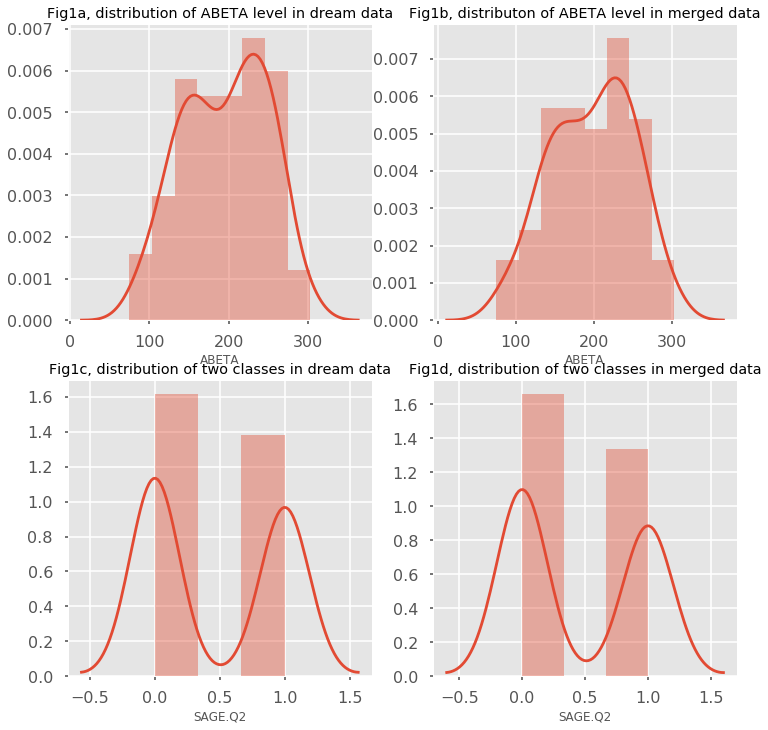

In [12]:
# Check distribution of amyloid-beta 42 level (ABETA) and class (SAGE.Q2)
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12,12))
sns.distplot(dream_data['ABETA'], ax=axes[0,0])
axes[0,0].set_title("Fig1a, distribution of ABETA level in dream data")
sns.distplot(data_common['ABETA'], ax=axes[0,1])
axes[0,1].set_title("Fig1b, distributon of ABETA level in merged data")
sns.distplot(dream_data['SAGE.Q2'], ax=axes[1,0])
axes[1,0].set_title("Fig1c, distribution of two classes in dream data")
sns.distplot(data_common['SAGE.Q2'], ax=axes[1,1])
axes[1,1].set_title("Fig1d, distribution of two classes in merged data")

2) Is there any correlation/difference in the two classes with regard to age, apo4 level, MMSE score, and year of collection?

Fig2 addresses these questions. The Age of patients in class 0 are more concentrated around 75 compared to class 1 (Fig2a). The year of collection of patient samples in class 0 are more spread out than in class 1 (Fig2d). The Apoe4 level in class 0 is much more concentrated near 0, whereas class 1 shows more variation in both directions (Fig2b). When comparing Apoe4 level with ABETA level, there is a clear negative correlation between the two (Fig2f). The MMSE score distribution in class 0 is lower than in class 1 (Fig2c). The scatterplot comparing ABETA level vs MMSE score (Fig2e) showed similar trend, implying high levels of beta-amyloid might correlate with lower cognition.

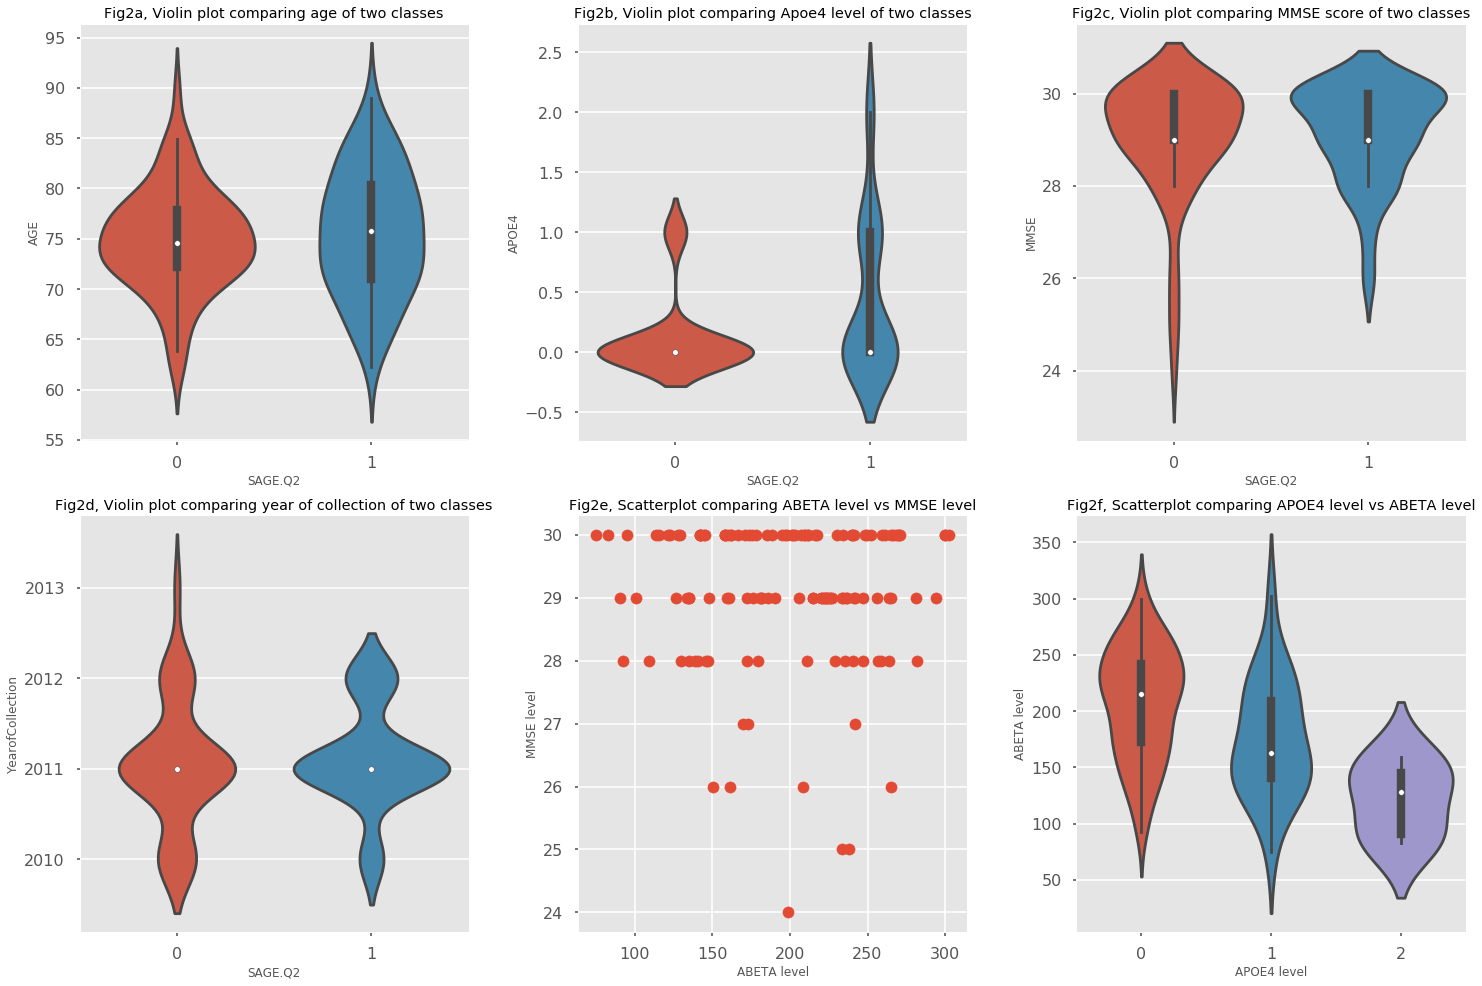

In [13]:
# Check distribution of amyloid-beta 42 level (ABETA) and class (SAGE.Q2)
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(21,15))
sns.violinplot(data_common['SAGE.Q2'], data_common['AGE'], ax=axes[0,0])
axes[0,0].set_title("Fig2a, Violin plot comparing age of two classes")

sns.violinplot(data_common['SAGE.Q2'], data_common['APOE4'], ax=axes[0,1])
axes[0,1].set_title("Fig2b, Violin plot comparing Apoe4 level of two classes")

sns.violinplot(data_common['SAGE.Q2'], data_common['MMSE'], ax=axes[0,2])
axes[0,2].set_title("Fig2c, Violin plot comparing MMSE score of two classes")

sns.violinplot(data_common['SAGE.Q2'], data_common.YearofCollection.convert_objects(convert_numeric=True), ax=axes[1,0])
axes[1,0].set_title("Fig2d, Violin plot comparing year of collection of two classes")

axes[1,1].scatter(data_common['ABETA'],data_common['MMSE'])
axes[1,1].set_xlabel('ABETA level')
axes[1,1].set_ylabel('MMSE level')
axes[1,1].set_title("Fig2e, Scatterplot comparing ABETA level vs MMSE level")

sns.violinplot(data_common['APOE4'], data_common['ABETA'], ax=axes[1,2])
axes[1,2].set_ylabel('ABETA level')
axes[1,2].set_xlabel('APOE4 level')
axes[1,2].set_title("Fig2f, Scatterplot comparing APOE4 level vs ABETA level")

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

3) How does high level look of gene expression profile differ between the two classes?

To address this question, we made a heatmap plot with each row correspond to a patient sample with class label on the side, each column correspond to a gene (We included 100 random genes in the plot for illustration purposes). If the gene expression profile of the two classes are distinctly different, we would expect the heatmap clustering on the y-axis (class bar on the left side of the heatmap) be very well separated between the two classes (red vs blue). The heatmap suggests the gene expression profiles between the two classes are not distinctly different based on this limited subset of genes. However, some of the samples do cluster close, showing thick red/blue class bars on the left, suggesting there might be potential that gene expression profile can help separate the two classes.

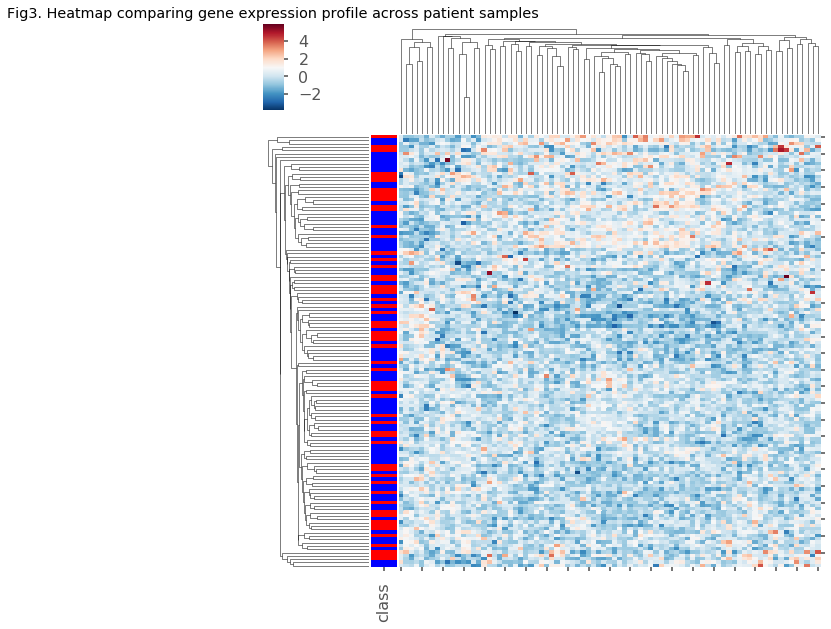

In [14]:
## Check gene expression profile difference by heatmap visualization
select_data = data_common[data_common.columns[19:100]]
select_data = select_data.convert_objects(convert_numeric=True)
select_data['class'] = data_common['SAGE.Q2']
exp_table = select_data.pop('class')
exp = dict(zip(exp_table.unique(), 'rbg'))
row_colors = exp_table.map(exp)
g = sns.clustermap(select_data, row_colors=row_colors, z_score=1, cmap="RdBu_r", mask=select_data.isnull());
plt.setp(g.ax_heatmap.set_yticklabels(''));
plt.setp(g.ax_heatmap.set_xticklabels(''));
plt.title("Fig3. Heatmap comparing gene expression profile across patient samples")

The basic data cleaning and EDA suggested gene expression profile might be able to help classifying the ABETA groups. In order to confirm this, further feature selection and dimension reduction like PCA need to be applied for modeling. For the modeling part, this can be pursued as either classification or regression. However, due the limitation of time and effort, we decide to focus the modeling the part 2 of the project - predicting mental scores from MRI image data.

### PART 2: Predicting mental state (MMSE) from brain imaging data (MRI)


In the second part of the project, we focus on the question if we can predict the mental state of a patient from brain imaging data. In the ADNI dataset, the mental state is represented by the Mini-Mental State Exam (MMSE) score which is the variable that we are trying to predict in this part of the project.
Since the psychological pathology develops relatively late in the disease progression, it would be advantageous to be able to predict the mental state from MRI brain imaging data which is routinely acquired in clinical settings (e.g. to exclude other types of dementia). In our analysis, we follow closely the the guidelines given in the AD Big Data Dream Challenge Subchallenge 3 (https://www.synapse.org/#!Synapse:syn2290704/wiki/64635).   
  
We downloaded the data for this challenge from https://ida.loni.usc.edu/pages/access/studyData.jsp?categoryId=43&subCategoryId=94 (password-protected login).

Initial Data Exploration:
The data in the baseline_data.csv file consists of 628 rows corresponding to unique observations of 628 patients. It contains 2150 measurements of brain geometry derived from 3D MRI images, e.g. area, thickness, curvature, etc. of different brain regions. It can be assumed that many of these variables are correlated with each other because of geometrical necessity.
The spreadsheeet also contains demographic data such as education, ethnicity, gender, race and age as well as some diagnostic data: MMSE score, Diagnosis, Apoe4 genotype. The Apoe4 allele is a polymorphism of the Apo E gene that is associated with AD susceptibility. In addition, there is an indicator variable for Apoe4 imputation.  

In [15]:
# we define a function to calculate the Concordance Correlation Coefficient (a measure to evaluate our models)
def ccc_function(y,y_hat):
    pcc, _ = pearsonr(y_hat,y)
    ccc = 2 * pcc * y.std() * y_hat.std()/(y.var() + y_hat.var() + (y.mean() - y_hat.mean())**2)
    return ccc

In [16]:
# function to evaluate our quantitative models and store the result in a summary dictionary
def evaluate_and_store(y_train,y_hat_train,y_test,y_hat_test,name,summary):
    # input:
    # y_train,y_hat_train,y_test,y_hat_test
    # summary: dictionary with fields model name, R2train, R2test, PCC and CCC
    pcc, _ = pearsonr(y_test,y_hat_test)
    ccc = ccc_function(y_test,y_hat_test)
    r2train = r2_score(y_train,y_hat_train)
    r2test = r2_score(y_test,y_hat_test)
    summary['model name'].append(name)
    summary['R2train'].append(r2train)
    summary['R2test'].append(r2test)
    summary['PCC'].append(pcc)
    summary['CCC'].append(ccc)
    return r2train,r2test,pcc,ccc,summary

# set up a summary dictionary
summary = {'model name':[],'R2train':[],'R2test':[],"PCC":[],'CCC':[]}


## Data Cleaning and EDA

  
  
We load the data and have a look at the imaging part and the demographic part.

In [17]:
#read data from file
data = pd.read_csv('baseline_data.csv')
print(data.shape)
# a lot more predictors than observations, lots of potential for overfitting

print(len(data.RID.unique()))
# no doubles in patient ID, so we can keep rows as patients/observations

#split data into image data and demographic data
image_data = data.iloc[:,:-13].copy()
demographic = data.iloc[:,-13:].copy()
mmse = data['MMSE']
# for diagnosis: CN = 0, LMCI = 1, AD = 2
dx = (data['DX.bl'] == 'LMCI') * 1. + (data['DX.bl'] == 'AD') * 2.

display(image_data.head())
display(demographic.head())

(628, 2163)
628


,area.1002,area.1003,area.1005,area.1006,area.1007,area.1008,area.1009,area.1011,area.1012,area.1013,...,Thickness..thickinthehead..2021,Thickness..thickinthehead..2022,Thickness..thickinthehead..2024,Thickness..thickinthehead..2025,Thickness..thickinthehead..2028,Thickness..thickinthehead..2029,Thickness..thickinthehead..2030,Thickness..thickinthehead..2031,Thickness..thickinthehead..2034,Thickness..thickinthehead..2035
0,612.577638,2514.366512,1652.050796,731.718725,3794.131041,5012.960558,4951.994756,5666.361234,2568.454160,3147.024829,...,0.2927,0.3276,0.3645,0.4358,0.4446,0.3887,0.4558,0.4107,0.3230,0.4806
1,735.292087,2435.629408,1947.966106,721.230657,4101.035394,4469.814924,4002.936490,5427.875646,2778.342103,3907.628206,...,0.3240,0.3247,0.3886,0.4416,0.4823,0.3790,0.4650,0.4499,0.3923,0.5315
2,1080.976588,2190.801306,1613.620315,636.078912,5146.969073,6192.609394,4640.889149,6854.023127,3282.902615,3677.408865,...,0.2343,0.2491,0.2727,0.3267,0.3098,0.3001,0.3069,0.3129,0.2369,0.3357
3,840.850798,2293.601605,1599.807666,729.344575,3351.924971,4231.417941,3991.795466,5047.106646,2599.222056,3339.590461,...,0.2643,0.2978,0.3116,0.3823,0.3976,0.3235,0.3808,0.3769,0.2902,0.4899
4,592.882184,1827.195664,1479.821407,535.558408,3459.934118,5063.103074,3583.954659,4120.492969,2462.352998,2737.467877,...,0.2603,0.3267,0.3871,0.4370,0.4861,0.3592,0.4216,0.4238,0.3356,0.4893


,directory.id,Subject,RID,Image.Data.ID,DX.bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,APOE4,MMSE,imputed_genotype
0,178eeac87ff2460568a8709ba32f9b1e,002_S_0295,295,45108,CN,84.8,Male,18,Not Hisp/Latino,White,1,28,True
1,4d953ce78fb484052e8b735e5493770a,002_S_0413,413,45117,CN,76.3,Female,16,Not Hisp/Latino,White,0,29,True
2,da022a5df80d136d3aa26bfa06702278,002_S_0619,619,48617,AD,77.5,Male,12,Not Hisp/Latino,White,2,22,False
3,7d700a43e372c9dfabd6c2dfdc0edcf8,002_S_0685,685,40683,CN,89.6,Female,16,Not Hisp/Latino,White,0,30,True
4,c033f6026da1179ab7b5f7e4f5559f59,002_S_0729,729,40708,LMCI,65.1,Female,16,Not Hisp/Latino,White,1,27,True


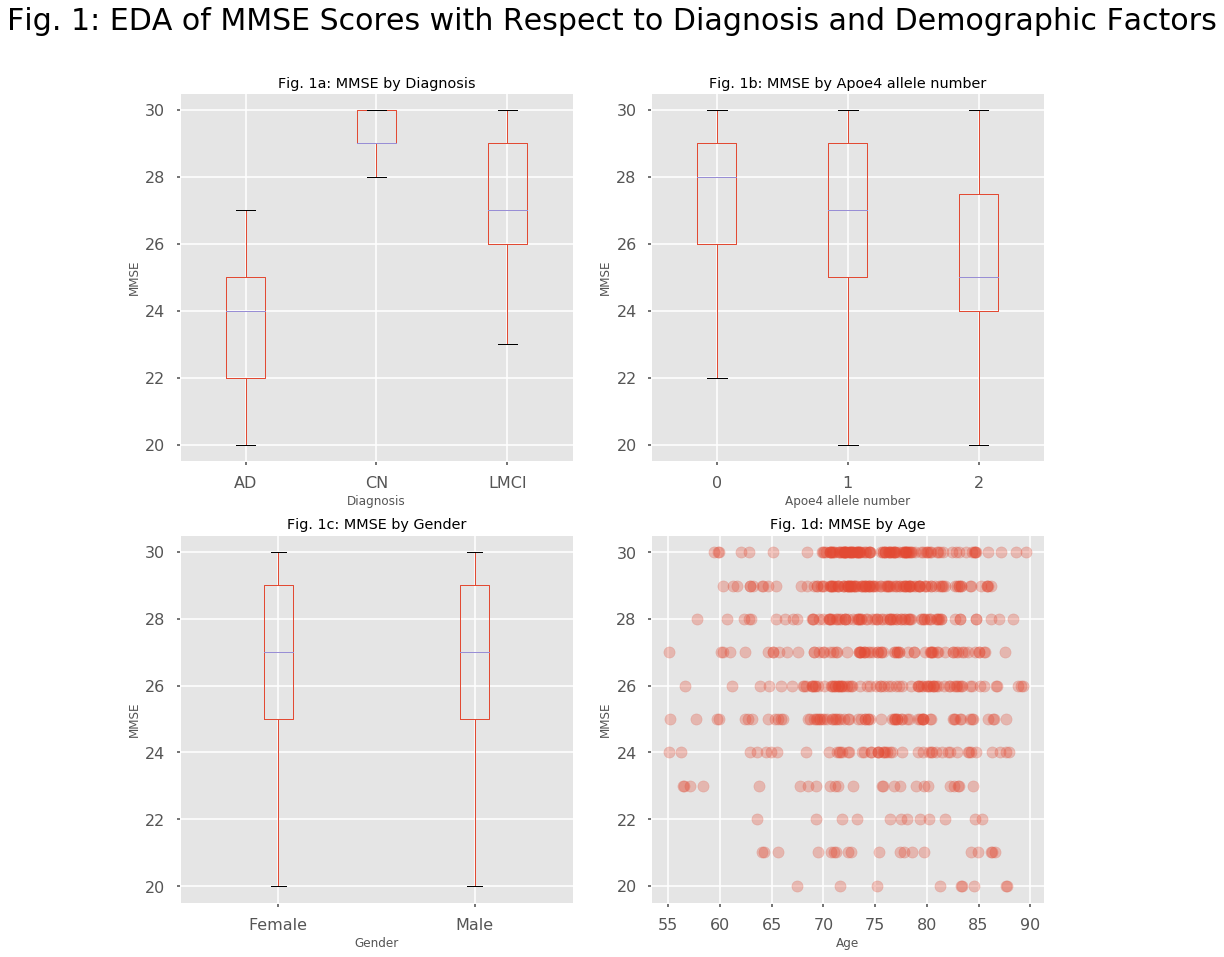

In [18]:
fig1 = plt.figure(figsize = [15,15])


plt.subplot(2,2,1)
ax = plt.gca()
data.boxplot('MMSE',by = ['DX.bl'], ax = ax)
plt.title('Fig. 1a: MMSE by Diagnosis')
plt.xlabel('Diagnosis')
plt.ylabel('MMSE')

plt.subplot(2,2,2)
ax = plt.gca()
data.boxplot('MMSE',by = ['APOE4'], ax = ax)
plt.title('Fig. 1b: MMSE by Apoe4 allele number')
plt.xlabel('Apoe4 allele number')
plt.ylabel('MMSE')

plt.subplot(2,2,3)
ax = plt.gca()
data.boxplot('MMSE',by = ['PTGENDER'], ax = ax)
plt.title('Fig. 1c: MMSE by Gender')
plt.xlabel('Gender')
plt.ylabel('MMSE')

plt.subplot(2,2,4)
ax = plt.gca()
plt.scatter(data['AGE'],mmse,alpha=0.3)
plt.title('Fig. 1d: MMSE by Age')
plt.xlabel('Age')
plt.ylabel('MMSE');


fig1.suptitle('Fig. 1: EDA of MMSE Scores with Respect to Diagnosis and Demographic Factors',fontsize= 30);

There is a clear correlation of MMSE score with the diagnosis of the patient. Healthy control patients (CN) have an MMSE score near the maximum of 30, whereas patients with light cognitive impairment (LMCI) have a lower median MMSE and Alzheimer's disease patients (AD) have the lowest median MMSE score.  This indicates that MMSE can be used to predict Alzheimer's disease or dementia in general.  
The MMSE score is also strongly correlated with the Apoe4 genotype. In particular, individuals that are homozygous for the Apoe4 allele, i.e. they have 2 copies of it, display a lower MMSE score.  
On the other hand, other demographic predictors like gender or age do not appear to be strongly correlated with the MMSE score.  
  
   
We now try to find the features in the imaging data that are most correlated with the MMSE score:

In [19]:
# find the image data columns that are most correlated with mmse

corr_coefs = []
pvals = []

for column in image_data.columns.values:
    coef,pval = pearsonr(image_data[column],mmse)
    corr_coefs.append(coef)
    pvals.append(pval)
    
print("image measurements most closely correlated with mmse score:")
best6 = image_data.columns.values[np.argsort(pvals)[:6]]
print(best6)


image measurements most closely correlated with mmse score:
['FreeSurfer.thickness..mean.1006' 'FreeSurfer.thickness..mean.2006'
 'FreeSurfer.thickness..25..1006' 'FreeSurfer.thickness..median.1006'
 'FreeSurfer.thickness..75..1006' 'FreeSurfer.thickness..25..1009']


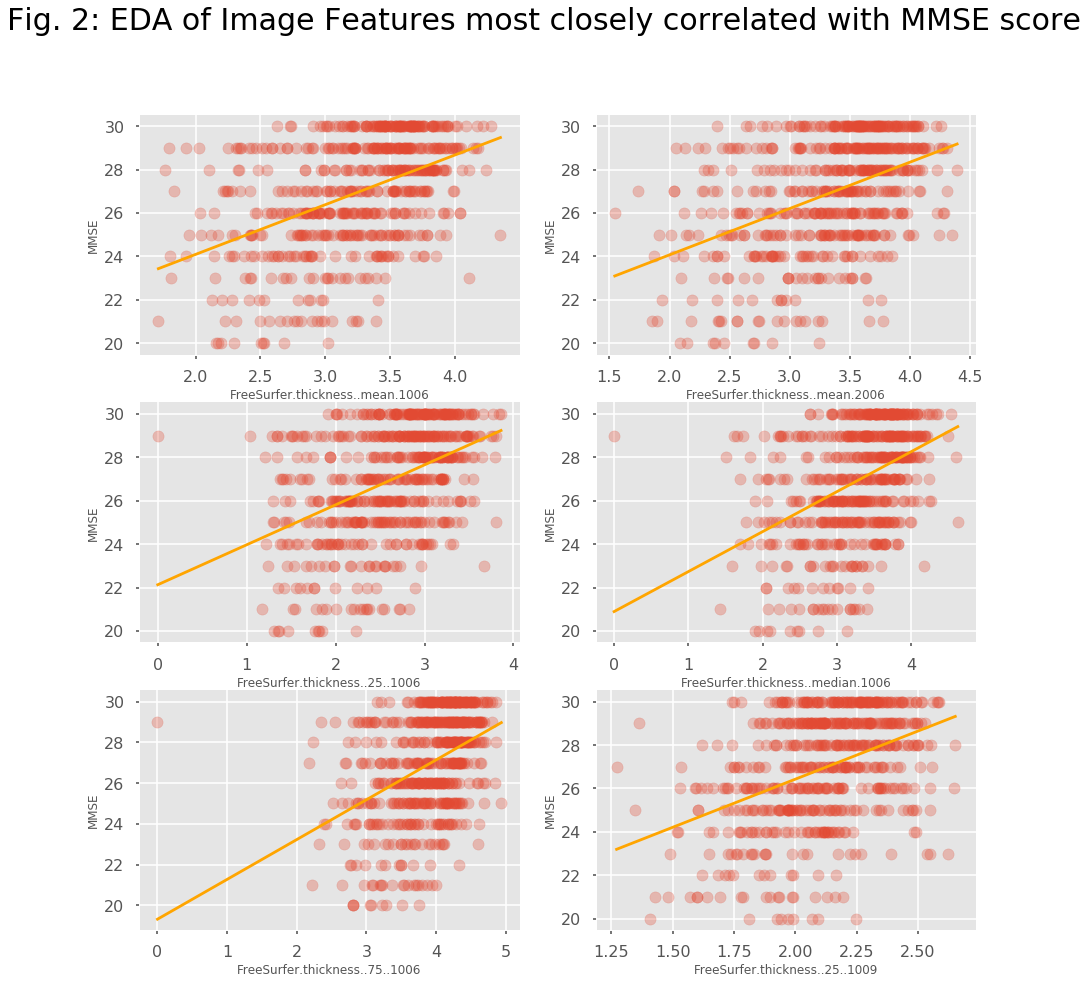

In [20]:
# plot mmse vs most closely correlated image measurements
fig2 = plt.figure(figsize= [15,15])

for i,feature in enumerate(best6):
    plt.subplot(3,2,i+1)
    plt.scatter(image_data[feature],mmse,alpha=0.3)
    plt.xlabel(feature)
    plt.ylabel('MMSE')
    beta1,beta0 = np.polyfit(image_data[feature],mmse,deg=1)
    f = lambda x: beta1 * x + beta0
    x = np.array([np.min(image_data[feature]), np.max(image_data[feature])])
    plt.plot(x,f(x),c='orange')
    sns.despine()
fig2.suptitle('Fig. 2: EDA of Image Features most closely correlated with MMSE score',fontsize= 30);  

Some of the features in the imaging data appear to be strongly correlated with the MMSE score which makes the analysis/prediction promising. 
We also notice that we now have 2159 predictors which is a lot more than the 628 observations we have in our complete dataset. This causes a big danger of overfitting any training data.  
We next clean up the demographic variables and split our data into training and test sets. We group all the predictors (demographic + MRI imaging) together and extract 2 outcome variables: 1.) the MMSE score which we want to predict, and 2.) the diagnosis which we will use to evaluate the usefulness of our MMSE prediction in the last part.  
Then we will check if we  have multi-colinearity in the imaging predictors.

In [21]:
# clean up demographic variables

# impute Unknown as Not Hisp/Latino and turn into binary with Hisp/Latino as 1.0, Non-Hisp/Latino as 0.0
demographic['PTETHCAT'] = (demographic.PTETHCAT == 'Hisp/Latino') * 1.

# race and number of Apoe4 alleles are turned into dummy variables
demographic = pd.get_dummies(demographic,columns=['PTRACCAT','APOE4'],drop_first=True)

# turn gender into a binary variable with Female = 1.0
demographic['PTGENDER'] = (demographic.PTGENDER == 'Female') * 1.

# change imputed_genotype from boolean to 0.0/1.0
demographic['imputed_genotype'] = (demographic.imputed_genotype == True)* 1.

# get X and y ; we have 2 different outcome variables: y = MMSE score for the main body of this analysis and
# y_dx = diagnosis for evaluating our predicted MMSE in the last part
y = mmse
y_dx = dx

image_columns = image_data.columns.values

# we discard the ID columns and the diagnosis column which would give away too much
demographic_columns = ['AGE','PTGENDER','PTEDUCAT','PTETHCAT','imputed_genotype','PTRACCAT_Black','PTRACCAT_White','APOE4_1','APOE4_2']


# and concatenate the image and remaining demographic data
X = pd.concat([image_data,demographic[demographic_columns]],axis=1)
print('number of observations: ',X.shape[0])
print('number of predictors: ',X.shape[1])

#check that there is no NaN's in the data
print('number of NULL values: ',np.sum(np.sum(X.isnull())))
# no NaN's

# train test split: we have 2 different outcome variables: y = MMSE score for the main body of this analysis and
# y_dx = diagnosis for evaluating our predicted MMSE in the last part
X_train, X_test, y_train, y_test, y_dx_train, y_dx_test = train_test_split(X,y,y_dx,train_size = 0.75,random_state=8)


# standardize training and test
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

number of observations:  628
number of predictors:  2159
number of NULL values:  0


## Checking Multi-Colinearity in the Imaging Data
  
  
    
We calculate a correlation matrix between the predictors and display it as a heatmap.

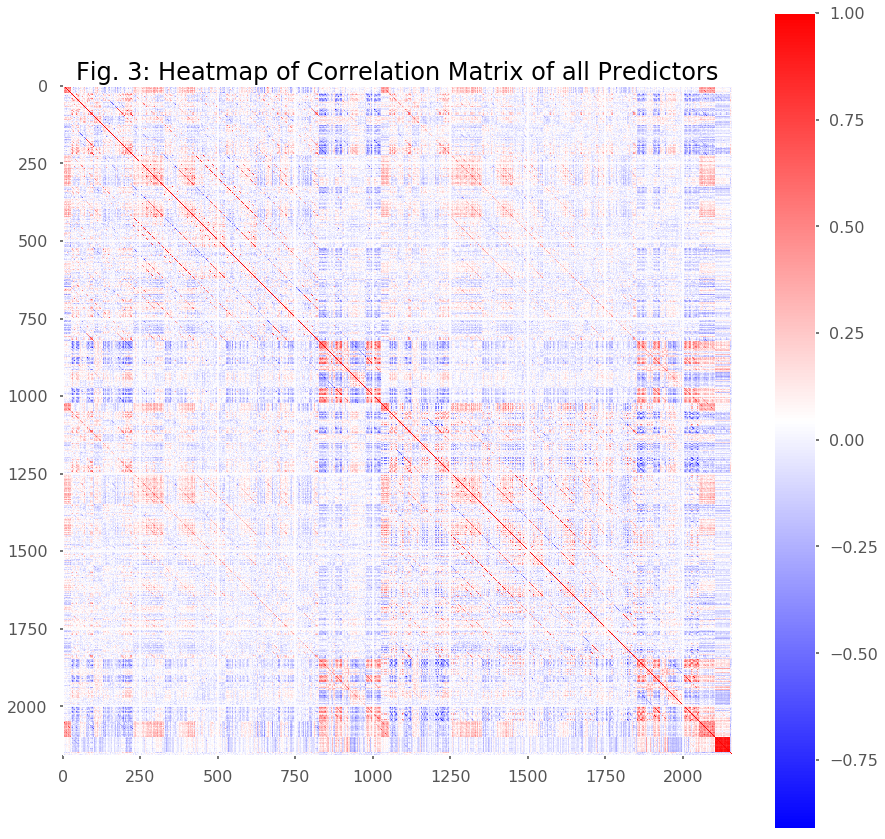

In [22]:
# get and plot correlation matrix
corr_mat = np.corrcoef(X_train.as_matrix().T)

# plot correlation matrix
fig3 = plt.figure(figsize = [15,15])
ax = plt.gca()
plt.set_cmap("bwr")
heatmap = plt.imshow(corr_mat)
plt.title('Fig. 3: Heatmap of Correlation Matrix of all Predictors',fontsize=24);
plt.colorbar(heatmap);

There is a lot of colinearity between the predictors in the imaging data. Colinear variables appear to be organized in ordered blocks. In order to get a working prediction model, we will have to reduce the dimensionality and co-linearity  to reduce the danger of overfitting to the training set.

## Baseline Model: Simple Linear Regression

We first try a simple linear regression model with all predictors and MMSE as the outcome.

In [23]:

# try a super-simple linear regression model on all predictors
simple_est = LinearRegression(fit_intercept = True)
simple_est.fit(X_train,y_train)
y_hat_train = simple_est.predict(X_train)
y_hat_test = simple_est.predict(X_test)

name = 'linear regression with all predictors'
r2train, r2test, pcc, ccc, summary = evaluate_and_store(y_train,y_hat_train,y_test,y_hat_test,name,summary)

print(name,': ')
print('R2 score on training set: ',r2train)
print('R2 score on validation set: ',r2test)
print("Pearson's correlation coefficient between estimate and ground truth(test set)", pcc)
print("Concordance correlation coefficient between estimate and ground truth(test set)", ccc)

linear regression with all predictors : 
R2 score on training set:  1.0
R2 score on validation set:  -0.575703582103
Pearson's correlation coefficient between estimate and ground truth(test set) 0.292637073937
Concordance correlation coefficient between estimate and ground truth(test set) 0.29124810158


Because of the large number of predictors and the multi-colinearity of the predictors, the model with all predictors suffers from high variance. Overall, variance appears to be the biggest problem in predicting this dataset. We will use principal components analysis, stepwise feature selection and ensemble strategies to reduce the dimensionality and eliminate colinearity. In addition, we will use regularization to further reduce variance problems.

## Principal Component Analysis and Regularized Linear Regression
  
    
    
First, we reduce the dimensionality by principal component analysis and keep enough principal components that capture 90% of the variance in the data. 

In [24]:
# PCA transformation with PCs that account for 90% of variance in training set
fullpca = PCA(n_components = 0.9,svd_solver = 'full')
X_train_pca = fullpca.fit_transform(X_train)
X_test_pca = fullpca.transform(X_test)
total_pcs = X_train_pca.shape[1]
print("Number of PCs accounting for 90% of variance: ", total_pcs)

Number of PCs accounting for 90% of variance:  197


We still have 197 predictors left after principal component analysis. Let's try a simple linear regression model:

In [25]:
# try a simple linear regression model without regularization on all 197 PCs
pca_lin_est = LinearRegression(fit_intercept = True)
pca_lin_est.fit(X_train_pca,y_train)
y_hat_train = pca_lin_est.predict(X_train_pca)
y_hat_test = pca_lin_est.predict(X_test_pca)

name = 'linear regression on {} PCs'.format(total_pcs)
r2train, r2test, pcc, ccc, summary = evaluate_and_store(y_train,y_hat_train,y_test,y_hat_test,name,summary)

print(name,': ')
print('R2 score on training set: ',r2train)
print('R2 score on validation set: ',r2test)
print("Pearson's correlation coefficient between estimate and ground truth(test set)", pcc)
print("Concordance correlation coefficient between estimate and ground truth(test set)", ccc)

linear regression on 197 PCs : 
R2 score on training set:  0.607144507434
R2 score on validation set:  0.146129866785
Pearson's correlation coefficient between estimate and ground truth(test set) 0.462698583976
Concordance correlation coefficient between estimate and ground truth(test set) 0.434770218566


We still have a relatively high discrepancy between performance on the training and test set which is indicative of variance problems. Even though we have eliminated co-linearity between predictors through PCA, this does not mean that each of our predictors is correlated with our outcome variable MMSE. We will try different types of regularization to reduce variance and improve our bias/variance trade-off.  
We first try ridge regularization with cross-validation to identify the ideal regularization weight hyper-parameter, then train on the whole training set with the optimal parameter.

In [26]:
# try ridge regularization
alphas = [100000,50000,10000,5000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01]

ridge_pca_est = RidgeCV(alphas=alphas,fit_intercept = True,cv=5)
ridge_pca_est.fit(X_train_pca,y_train)
best_alpha = ridge_pca_est.alpha_

# now train on whole training set with best alpha
ridge_pca_est = Ridge(alpha=best_alpha,fit_intercept = True)
ridge_pca_est.fit(X_train_pca,y_train)
y_hat_train = ridge_pca_est.predict(X_train_pca)
y_hat_test = ridge_pca_est.predict(X_test_pca)

name = 'ridge regression with {} PCs'.format(total_pcs)
r2train, r2test, pcc, ccc, summary = evaluate_and_store(y_train,y_hat_train,y_test,y_hat_test,name,summary)

print(name,': ')
print('Regularization parameter: ', best_alpha)
print('R2 score on training set: ',r2train)
print('R2 score on validation set: ',r2test)
print("Pearson's correlation coefficient between estimate and ground truth(test set)", pcc)
print("Concordance correlation coefficient between estimate and ground truth(test set)", ccc)

ridge regression with 197 PCs : 
Regularization parameter:  5000
R2 score on training set:  0.471061556011
R2 score on validation set:  0.265014380849
Pearson's correlation coefficient between estimate and ground truth(test set) 0.518424013095
Concordance correlation coefficient between estimate and ground truth(test set) 0.419587774173


This has improved our R2 score on the test set quite dramatically. We try another type of regularization, Elastic Net regularization. This method combines L1 (Lasso) and L2 (Ridge) regularization. We cross-validate for regularization strength and the ratio between L1 and L2.

In [27]:
# elastic net regularization
ratios = [.001,.01,.1, .5, .7, .9, .95, .99, 1]
elnet_est = ElasticNetCV(l1_ratio = ratios, alphas=alphas,fit_intercept = True,cv=5)
elnet_est.fit(X_train_pca,y_train)
best_alpha = elnet_est.alpha_
best_ratio = elnet_est.l1_ratio_

elnet_est = ElasticNet(l1_ratio = best_ratio, alpha=best_alpha,fit_intercept = True)
elnet_est.fit(X_train_pca,y_train)
y_hat_train = elnet_est.predict(X_train_pca)
y_hat_test = elnet_est.predict(X_test_pca)

name = 'Elastic Net regression with {} PCs'.format(total_pcs)
r2train, r2test, pcc, ccc, summary = evaluate_and_store(y_train,y_hat_train,y_test,y_hat_test,name,summary)

print(name,': ')
print('Regularization parameter: ', best_alpha)
print('L1 ratio: ',best_ratio)
print('R2 score on training set: ',r2train)
print('R2 score on validation set: ',r2test)
print("Pearson's correlation coefficient between estimate and ground truth(test set)", pcc)
print("Concordance correlation coefficient between estimate and ground truth(test set)", ccc)

Elastic Net regression with 197 PCs : 
Regularization parameter:  10.0
L1 ratio:  0.01
R2 score on training set:  0.430632422622
R2 score on validation set:  0.267113344982
Pearson's correlation coefficient between estimate and ground truth(test set) 0.52064312814
Concordance correlation coefficient between estimate and ground truth(test set) 0.41525211834


The Elastic Net regularization has not improved our model compared to ridge regularization. Moreover, the optimal ratio between L1 and L2 regularization  is very close to pure L2 regularization, further confirming ridge regularization as the optimal decision in this scenario


Optimal number of principal components:  20
linear regression with 20 PCs : 
R2 score on training set:  0.321961145795
R2 score on validation set:  0.226915996482
Pearson's correlation coefficient between estimate and ground truth(test set) 0.486073194638
Concordance correlation coefficient between estimate and ground truth(test set) 0.41508971522


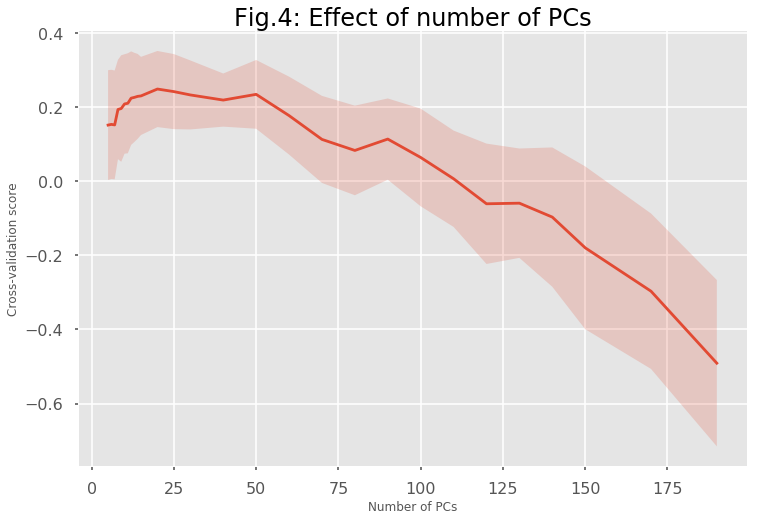

In [28]:
# find optimal number of PCs to include in model by determining the 5fold crossvalidation r2 score 
# in a linear regression model 
scorelist = []

#pcs = range(1,total_pcs+1)
pcs = [5,6,7,8,9,10,11,12,13,14,15,20,25,30,40,50,60,70,80,90,100,110,120,130,140,150,170,190]
for use_pcs in pcs:
    scores = cross_val_score(pca_lin_est,X_train_pca[:,:use_pcs],y_train,cv=5)
    scorelist.append(scores)
    
#plot crossvalidation score means and std as a function of number of PCs
score_array = np.vstack(scorelist)    
valid_means = score_array.mean(axis=1)
valid_stds = score_array.std(axis=1)

fig4 = plt.figure(figsize = [12,8])
plt.title('Fig.4: Effect of number of PCs', fontsize = 24)
ax = plt.gca()
plt.plot(pcs,valid_means)
ax.fill_between(pcs,valid_means+valid_stds,valid_means-valid_stds,alpha = 0.2)
ax.set_ylabel('Cross-validation score')
ax.set_xlabel('Number of PCs')
sns.despine()

# determine optimal number of PCs based on crossvalidation score and fit a linear regression model
optimal_pcs = pcs[np.argmax(valid_means)]
print("\nOptimal number of principal components: ",optimal_pcs)


# fit to complete training set with best set of predictors (PCs)
pca_lin_est.fit(X_train_pca[:,:optimal_pcs],y_train)

# get stats
y_hat_train = pca_lin_est.predict(X_train_pca[:,:optimal_pcs])
y_hat_test = pca_lin_est.predict(X_test_pca[:,:optimal_pcs])

name = 'linear regression with {} PCs'.format(optimal_pcs)
r2train, r2test, pcc, ccc, summary = evaluate_and_store(y_train,y_hat_train,y_test,y_hat_test,name,summary)

print(name,': ')
print('R2 score on training set: ',r2train)
print('R2 score on validation set: ',r2test)
print("Pearson's correlation coefficient between estimate and ground truth(test set)", pcc)
print("Concordance correlation coefficient between estimate and ground truth(test set)", ccc)

The test R2 score of this unregularized model with 20 PCs is comparable to the Ridge regression model on all 197 PCs. Further regularization does not improve this model (data not shown).

## Step-wise feature selection based on cross-validation score
  
    
In lieu of PCA, we also try dimensionality reduction by step-wise feature selection. We first split our training set into a smaller training set to stepwise select predictors and a validation set to select the number of predictors to keep. We use a simple linear regression model for this purpose.

In [29]:
# we split off another validation set to choose the number of features 
X_train_sm, X_valid,y_train_sm,y_valid = train_test_split(X_train,y_train,test_size= 150,random_state = 7)

# now we select predictors stepwise by crossvalidation
all_predictors = X_train.columns.values
predictors = []

# add predictors step-wise
max_predictors = 30 
for k in range(1, max_predictors):
    
    if k == 1:
        used_predictors = []
    else:
        used_predictors = predictors[-1]
    
    # get currently unused predictors
    unused_predictors = list(set(all_predictors) - set(used_predictors))
    
    # add each of the unused predictors one at a time and store the mean of cross-validation scores
    xvalscores = []
    for predictor in unused_predictors:
        # cross validate with chosen predictors on small training set
        k_predictors = used_predictors + [predictor]
        X_train_k = X_train_sm[k_predictors]
        linreg_est = LinearRegression(fit_intercept = True)
        kf = KFold(n_splits=3, shuffle=True, random_state=7)
        score = cross_val_score(linreg_est,X_train_k,y_train_sm,cv=kf).mean()
        xvalscores.append(score)
    
    # then choose the predictor that gives the best cross-validation score and add it to the list of used predictors
    best_k = used_predictors + [unused_predictors[np.argmax(xvalscores)]]
    predictors.append(best_k)

linear regression with 5 predictors : 
optimal number of predictors:  5
predictors:  ['FreeSurfer.thickness..mean.1009', 'FreeSurfer.thickness..mean.2006', 'mean.curvature..kurtosis.1007', 'geodesic.depth..SD.1011', 'PTEDUCAT']
R2 score on training set:  0.347888052415
R2 score on validation set:  0.263384791347
Pearson's correlation coefficient between estimate and ground truth(test set) 0.522998265342
Concordance correlation coefficient between estimate and ground truth(test set) 0.457283947517


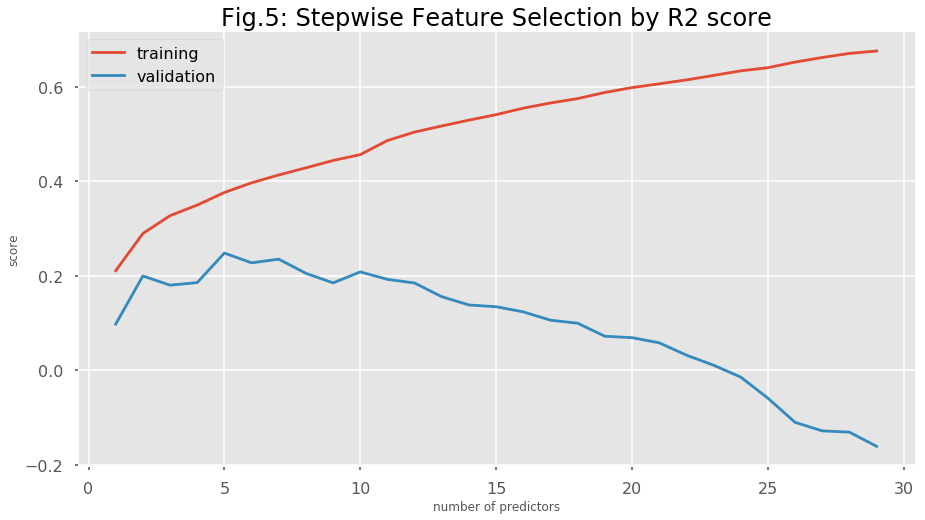

In [30]:
# we now choose the number of predictors based on the R2 score on the held-out validation set
train_scores = []
valid_scores = []
# loop through sets of predictors
for p in predictors:
    #fit a linear regression model with chosen set of predictors on small training set
    linreg_est.fit(X_train_sm[p],y_train_sm)
    
    # get R2 score for small training set and validation set
    y_hat_train_sm = linreg_est.predict(X_train_sm[p])
    y_hat_valid = linreg_est.predict(X_valid[p])
    
    train_scores.append(r2_score(y_train_sm,y_hat_train_sm))
    valid_scores.append(r2_score(y_valid,y_hat_valid))

# plot train and validation set scores as a function of number of predictors
fig5 = plt.figure(figsize= [15,8])
plt.plot(range(1, max_predictors),train_scores)
plt.plot(range(1, max_predictors),valid_scores)
plt.title('Fig.5: Stepwise Feature Selection by R2 score',fontsize=24)
plt.xlabel('number of predictors')
plt.ylabel('score')
plt.legend(['training','validation'])

# choose the model with the best test score
best_predictors = predictors[np.argmax(valid_scores)]

# extract best predictors to new dataframe
X_train_feat = X_train[best_predictors]
X_test_feat = X_test[best_predictors]

# fit linear regression model to complete (not small) training set and evaluate on training and test set
linreg_est = LinearRegression()
linreg_est.fit(X_train_feat,y_train)
y_hat_train = linreg_est.predict(X_train_feat)
y_hat_test = linreg_est.predict(X_test_feat)
name = 'linear regression with {} predictors'.format(len(best_predictors))
r2train, r2test, pcc, ccc, summary = evaluate_and_store(y_train,y_hat_train,y_test,y_hat_test,name,summary)

print(name,': ')
print('optimal number of predictors: ',len(best_predictors))
print('predictors: ',best_predictors)
print('R2 score on training set: ',r2train)
print('R2 score on validation set: ',r2test)
print("Pearson's correlation coefficient between estimate and ground truth(test set)", pcc)
print("Concordance correlation coefficient between estimate and ground truth(test set)", ccc)

This simple linear regression model with only 5 predictors a similar performance as the PCA models with an R2 score of 0.26.

In [31]:
# test if regularization improves the model
ridge_feat_est = RidgeCV(alphas=alphas,fit_intercept = True,cv=5)
ridge_feat_est.fit(X_train_feat,y_train)
best_alpha = ridge_feat_est.alpha_

# now train on whole training set with best alpha
ridge_feat_est.fit(X_train_feat,y_train)
y_hat_train = ridge_feat_est.predict(X_train_feat)
y_hat_test = ridge_feat_est.predict(X_test_feat)

name = 'linear regression model with Ridge regularization on {} PCA predictors'.format(total_pcs)
r2train, r2test, pcc, ccc, summary = evaluate_and_store(y_train,y_hat_train,y_test,y_hat_test,name,summary)

print(name,': ')
print("Regularization parameter for Ridge regularization: ",best_alpha)
print('R2 score on training set: ',r2train)
print('R2 score on validation set: ',r2test)
print("Pearson's correlation coefficient between estimate and ground truth(test set)", pcc)
print("Concordance correlation coefficient between estimate and ground truth(test set)", ccc)


linear regression model with Ridge regularization on 197 PCA predictors : 
Regularization parameter for Ridge regularization:  50
R2 score on training set:  0.346354646594
R2 score on validation set:  0.267638593243
Pearson's correlation coefficient between estimate and ground truth(test set) 0.522653783263
Concordance correlation coefficient between estimate and ground truth(test set) 0.441699871133


Regularization does not appear to improve the plain linear regression model further.

## Ensemble Methods
  
   
Ensemble methods like Random Forest Regression or Gradient Boosting are another way to reduce the number of features being considered in the model. We first try Random Forest Regression and crossvalidate to optimize the maximum depth of the trees on a relatively small number of trees (64), we fix the number of features to the square root of all features (46). We then increase the number of trees to 512 to acchieve a slightly better model. Because of the long time it takes to compute these Random Forests we did not perform an exhaustive grid search of all hyper-parameters.

In [32]:
# because the random forest regression takes to train a long time, we just optimize for the tree depth
# we set the max_features to 'sqrt' and the number of trees to 64
# rf = RandomForestRegressor(n_estimators = 64,max_features = 'sqrt',random_state=7)
rf = RandomForestRegressor(n_estimators = 64,max_features = 'sqrt',random_state=7)

parameters = {'max_depth':[i for i in range(3,15)]}
gs_rf = GridSearchCV(rf,parameters)
gs_rf.fit(X_train,y_train)
print(gs_rf.best_estimator_)
print('optimal max_depth: ',gs_rf.best_estimator_.max_depth)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=64, n_jobs=1,
           oob_score=False, random_state=7, verbose=0, warm_start=False)
optimal max_depth:  6


In [33]:
# we then increase the number of trees to improve our model
rf_est = RandomForestRegressor(n_estimators = 512,max_features = 'sqrt',max_depth = 7)
rf_est.fit(X_train,y_train)
y_hat_train = rf_est.predict(X_train)
y_hat_test = rf_est.predict(X_test)

name = 'Random Forest Regressor with all predictors'
r2train, r2test, pcc, ccc, summary = evaluate_and_store(y_train,y_hat_train,y_test,y_hat_test,name,summary)

print(name,': ')
print('R2 score on training set: ',r2train)
print('R2 score on validation set: ',r2test)
print("Pearson's correlation coefficient between estimate and ground truth(test set)", pcc)
print("Concordance correlation coefficient between estimate and ground truth(test set)", ccc)


Random Forest Regressor with all predictors : 
R2 score on training set:  0.797614336929
R2 score on validation set:  0.249720758769
Pearson's correlation coefficient between estimate and ground truth(test set) 0.507697810406
Concordance correlation coefficient between estimate and ground truth(test set) 0.361389204613


At least for the limited set of hyper-parameters we tested, the random forest model does not perform as well as our previous models.

We then tried a Gradient Boosting Regressor for our prediction using crossvalidation to determine the optimal depth of the individual estimators as well as the number of estimators. We then retrain on the complete training set and acchieve the best model performance so far.

In [34]:
# try Gradient Boosting
gbr = GradientBoostingRegressor()
parameters = {'max_depth':[i for i in range(1,5)],'n_estimators':[i*50 for i in range(1,4)]}
gs_gbr = GridSearchCV(gbr,parameters)
gs_gbr.fit(X_train,y_train)
print(gs_gbr.best_estimator_)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=50, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)


In [35]:
# retrain on the complete training set with optimal parameters
gbr_est = GradientBoostingRegressor(max_depth=4,n_estimators=100)
gbr_est.fit(X_train,y_train)

y_hat_train = gbr_est.predict(X_train)
y_hat_test = gbr_est.predict(X_test)


name = 'gradient boosting regressor with all predictors'
r2train, r2test, pcc, ccc, summary = evaluate_and_store(y_train,y_hat_train,y_test,y_hat_test,name,summary)
#display(pd.DataFrame(np.array([name,r2train, r2test, pcc, ccc]).reshape(1,-1),columns=['model name','R2 train','R2 test',\
#                                                                "Pearson's Correlation Coefficient",\
#                                                               "Concordance Correlation Coefficient"]))

print(name,': ')
print('R2 score on training set: ',r2train)
print('R2 score on validation set: ',r2test)
print("Pearson's correlation coefficient between estimate and ground truth(test set)", pcc)
print("Concordance correlation coefficient between estimate and ground truth(test set)", ccc)


gradient boosting regressor with all predictors : 
R2 score on training set:  0.996273889194
R2 score on validation set:  0.285321655084
Pearson's correlation coefficient between estimate and ground truth(test set) 0.535376303013
Concordance correlation coefficient between estimate and ground truth(test set) 0.459441767335


## Model Performance Comparison
  
  
To evaluate our models, we used 3 different metrics: R2 score, Pearson's correlation coefficient and Concordance correlation coefficient, all on the test set. The latter is the metric used in the AD DREAM challenge to score the leaderboard.

In [36]:
display(pd.DataFrame(summary)[['model name','R2train','R2test','PCC','CCC']])

,model name,R2train,R2test,PCC,CCC
0,linear regression with all predictors,1.000000,-0.575704,0.292637,0.291248
1,linear regression on 197 PCs,0.607145,0.146130,0.462699,0.434770
2,ridge regression with 197 PCs,0.471062,0.265014,0.518424,0.419588
3,Elastic Net regression with 197 PCs,0.430632,0.267113,0.520643,0.415252
4,linear regression with 20 PCs,0.321961,0.226916,0.486073,0.415090
5,linear regression with 5 predictors,0.347888,0.263385,0.522998,0.457284
6,linear regression model with Ridge regularizat...,0.346355,0.267639,0.522654,0.441700
7,Random Forest Regressor with all predictors,0.797614,0.249721,0.507698,0.361389
8,gradient boosting regressor with all predictors,0.996274,0.285322,0.535376,0.459442


The best model in all 3 evaluation metrics (R2 score, Pearson's correlation coefficient, Concordance correlation coefficient, all on test set) is the gradient boosting regressor. Assuming our test set is representative of the test set used for the AD DREAM challenge, our Concordance correlation coefficient of 0.47 would place us on rank 8 of the final leaderboard (https://www.synapse.org/#!Synapse:syn2290704/wiki/68513). The Pearson's correlation coefficient would place us even higher. We use our optimal model to visualize how our predicted MMSE scores compare to the true MMSE scores, both on the training set and test set. We also visualize the different diagnoses classes (CN = control, MCI = mild cognitive impairment and AD = Alzheimer's disease) in these diagrams.

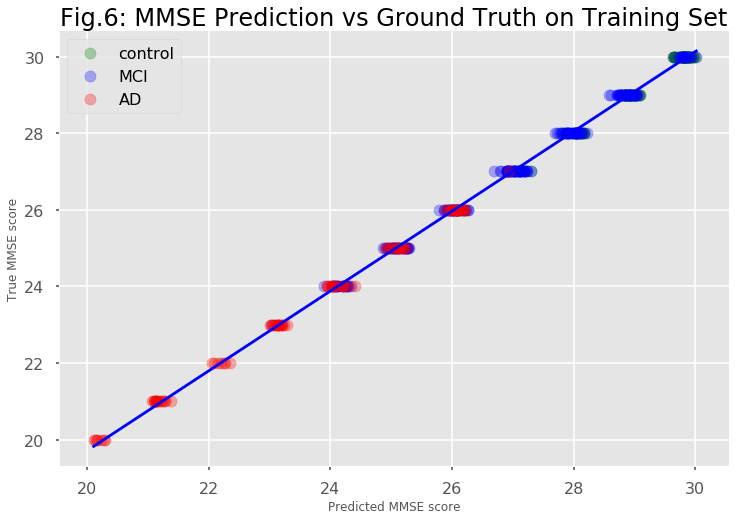

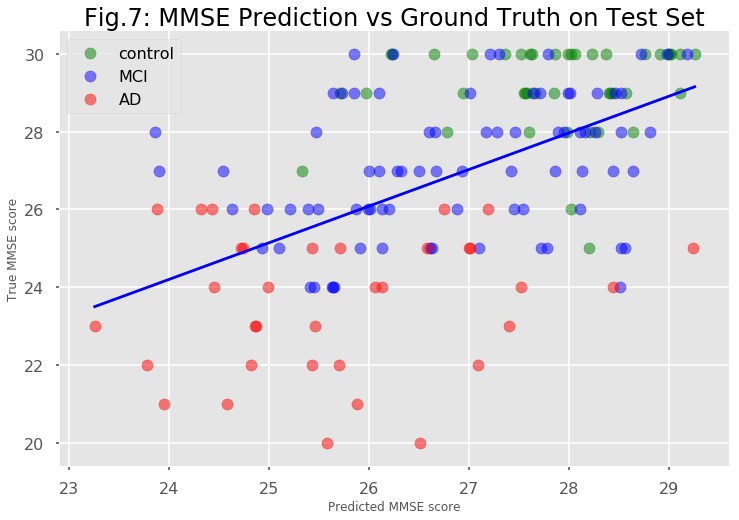

In [37]:
# visualization of the best model 

y_hat_train = gbr_est.predict(X_train)
y_hat_test = gbr_est.predict(X_test)

# indices for the 3 diagnoses
idx1 = y_dx_train == 0
idx2 = y_dx_train == 1
idx3 = y_dx_train == 2

# plot of prediction vs truth on training set
fig6 = plt.figure(figsize = [12,8])
plt.scatter(y_hat_train[idx1],y_train[idx1],alpha=0.3,c='green')
plt.scatter(y_hat_train[idx2],y_train[idx2],alpha=0.3,c='blue')
plt.scatter(y_hat_train[idx3],y_train[idx3],alpha=0.3,c='red')

plt.xlabel('Predicted MMSE score')
plt.ylabel('True MMSE score')
plt.legend(['control','MCI','AD'])

# plot regression line
beta1,beta0 = np.polyfit(y_hat_train,y_train,deg=1)
f = lambda x: beta1 * x + beta0
x = np.array([np.min(y_hat_train), np.max(y_hat_train)])
plt.plot(x,f(x),c='blue')

plt.title('Fig.6: MMSE Prediction vs Ground Truth on Training Set',fontsize=24)
sns.despine()

# plot of prediction vs truth on test set
idx1 = y_dx_test == 0
idx2 = y_dx_test == 1
idx3 = y_dx_test == 2

fig7 = plt.figure(figsize = [12,8])
plt.scatter(y_hat_test[idx1],y_test[idx1],alpha=0.5,c='green')
plt.scatter(y_hat_test[idx2],y_test[idx2],alpha=0.5,c='blue')
plt.scatter(y_hat_test[idx3],y_test[idx3],alpha=0.5,c='red')

plt.xlabel('Predicted MMSE score')
plt.ylabel('True MMSE score')
plt.legend(['control','MCI','AD'])
plt.title('Fig.7: MMSE Prediction vs Ground Truth on Test Set',fontsize=24)

#plot regression line
beta1,beta0 = np.polyfit(y_hat_test,y_test,deg=1)
f = lambda x: beta1 * x + beta0
x = np.array([np.min(y_hat_test), np.max(y_hat_test)])
plt.plot(x,f(x),c='blue')

sns.despine()

Based on the distribution of different diagnosis classes in this graph, it should be helpful to use the predicted MMSE in prediction of diagnoses.

## Influence of estimated MMSE on diagnosis prediction
  
  
We are first comparing three simple logistic regression classifiers: One that uses only the demographic data for predicting diagnosis, one that uses the actual MMSE score and one that uses our predicted MMSE score. The first achieves only 46% accuracy on the test set, whereas the second achieves 69%. The model with our predicted MMSE score is halfway between these 2 extremes with 56% accuracy.

In [38]:
# try to predict diagnosis based on demographic predictors only (logistic regression with xval for regularization)
X_est_train = X_train[demographic_columns].copy()
X_est_test = X_test[demographic_columns].copy()

Cs = [100000,50000,10000,5000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001]
logreg_clf = LogisticRegressionCV(Cs=Cs)
logreg_clf.fit(X_est_train,y_dx_train)
y_hatdx_train = logreg_clf.predict(X_est_train)
y_hatdx_test = logreg_clf.predict(X_est_test)

train_acc = np.sum(y_hatdx_train == y_dx_train)/len(y_dx_train)
test_acc = np.sum(y_hatdx_test == y_dx_test)/len(y_dx_test)

print('model with demographic factors only:')
print('training accuracy: ',train_acc)
print('test accuracy: ', test_acc)

model with demographic factors only:
training accuracy:  0.511677282378
test accuracy:  0.464968152866


In [39]:
# new model based on demographic predictors + true MMSE score
X_est_train['MMSE'] = y_train
X_est_test['MMSE'] = y_test

Cs = [100000,50000,10000,5000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001]
logreg_clf = LogisticRegressionCV(Cs=Cs)
logreg_clf.fit(X_est_train,y_dx_train)
y_hatdx_train = logreg_clf.predict(X_est_train)
y_hatdx_test = logreg_clf.predict(X_est_test)

train_acc = np.sum(y_hatdx_train == y_dx_train)/len(y_dx_train)
test_acc = np.sum(y_hatdx_test == y_dx_test)/len(y_dx_test)

print('model with demographic factors + true MMSE score:')
print('training accuracy: ',train_acc)
print('test accuracy: ', test_acc)

model with demographic factors + true MMSE score:
training accuracy:  0.713375796178
test accuracy:  0.694267515924


In [40]:
# new model based on demographic predictors + our predicted MMSE score
X_est_train['MMSE'] = y_hat_train
X_est_test['MMSE'] = y_hat_test

Cs = [100000,50000,10000,5000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001]
logreg_clf = LogisticRegressionCV(Cs=Cs)
logreg_clf.fit(X_est_train,y_dx_train)
y_hatdx_train = logreg_clf.predict(X_est_train)
y_hatdx_test = logreg_clf.predict(X_est_test)

train_acc = np.sum(y_hatdx_train == y_dx_train)/len(y_dx_train)
test_acc = np.sum(y_hatdx_test == y_dx_test)/len(y_dx_test)

print('model with demographic factors + our estimated MMSE score:')
print('training accuracy: ',train_acc)
print('test accuracy: ', test_acc)

model with demographic factors + our estimated MMSE score:
training accuracy:  0.72186836518
test accuracy:  0.573248407643


In order to getter a better estimate and a significance value for the improvement, we perform bootstrapping by resampling our training set with replacement, use the remaining observations as test set and determine the difference in test accuracies between the base model and our (putatively) improved model.

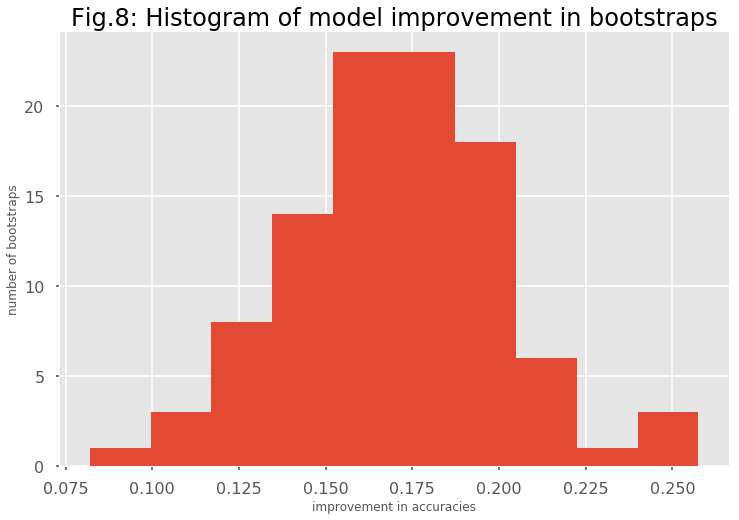

In [41]:
# get p-values for the effect of estimated mmse score using a paired t-test (one sample t-test on differences)
num_iterations = 100
train_size = X_est_train.shape[0]
data = pd.concat([pd.concat([X_est_train,X_est_test]),pd.concat([y_dx_train,y_dx_test])],axis=1).values

test_acc_diffs = []

for i in range(num_iterations):
    # prepare train and test sets
    train = resample(data, n_samples=train_size)
    test = np.array([x for x in data if x.tolist() not in train.tolist()])
    X_train_bs = train[:,:-1]
    y_train_bs = train[:,-1]
    X_test_bs = test[:,:-1]
    y_test_bs = test[:,-1]
    
    # fit base model without mmse
    logreg_clf = LogisticRegressionCV(Cs=Cs)
    logreg_clf.fit(X_train_bs[:,:-1],y_train_bs)
    y_hat_base = logreg_clf.predict(X_test_bs[:,:-1])
    acc_base = np.sum(y_hat_base == y_test_bs)/len(y_test_bs)
    
    # fit mmse model 
    logreg_clf.fit(X_train_bs,y_train_bs)
    y_hat_mmse = logreg_clf.predict(X_test_bs)
    acc_mmse = np.sum(y_hat_mmse == y_test_bs)/len(y_test_bs)
    
    test_acc_diffs.append(acc_mmse - acc_base)

fig8 = plt.figure(figsize = [12,8])
plt.hist(test_acc_diffs)
plt.xlabel('improvement in accuracies')
plt.ylabel('number of bootstraps')
plt.title('Fig.8: Histogram of model improvement in bootstraps',fontsize=24);

In [42]:
_,pval = ttest_1samp(test_acc_diffs,popmean=0)
print('mean improvement by inclusion of predicted MMSE score: ',np.mean(test_acc_diffs))
print('Null Hypothesis: Including predicted MMSE has no effect on accuracy of classifier')
print('p-value: ', pval)

mean improvement by inclusion of predicted MMSE score:  0.171083428693
Null Hypothesis: Including predicted MMSE has no effect on accuracy of classifier
p-value:  9.00462879262e-76


The improvement in test accuracies is roughly normally distributed and has a mean of 17%. Based on a paired t-test, these effects are highly significant.

## Discussion
  
  
We have shown that our best models can compete with other submissions to the AD DREAM challenge and even outperform 2/3 of the submissions. We have also shown that the predicted MMSE scores from our best model are good enough to significantly improve Alzheimer's Disease/Dementia diagnosis. However, given more time, there might be ways to further improve our model: We currently use preprocessed geometrical data to approximate brain morphology as our predictors; the raw MRI data might contain information that is not captured by this data. Training a deep neural net on raw MRI images might improve our prediction.  
It is remarkable that a number of our models is performing relatively well. Combining these models by stacking might further improve our prediction.